# Install Necessary Packages# It will take some time to load everything
deci_diffusion_pipeline = StableDiffusionPipeline.from_pretrained('Deci/DeciDiffusion-v1-0',
                                                   custom_pipeline='Deci/DeciDiffusion-v1-0',
                                                   torch_dtype=torch.float16
                                                   )

In [1]:
#install the packages using pip
!pip install --quiet git+https://github.com/huggingface/diffusers.git@d420d71398d9c5a8d9a5f95ba2bdb6fe3d8ae31f
!pip install --quiet ipython-autotime
!pip install --quiet transformers==4.34.1 accelerate==0.24.0 safetensors==0.4.0
!pip install --quiet ipyplot
#!pip install gradio
%load_ext autotime

time: 409 µs (started: 2024-01-09 09:16:43 +00:00)


In [2]:
!python --version

Python 3.9.13
time: 550 ms (started: 2024-01-09 09:16:48 +00:00)


In [3]:
import torch
import os
import time
from IPython.core.display import display, HTML

from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from diffusers import StableDiffusionPipeline

import os
import torch
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import time

/tmp/ipykernel_34/2535832417.py:4: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

time: 3.93 s (started: 2024-01-09 09:16:53 +00:00)


# Load pretrained model DeciDiffusion from repo

In [4]:
# It will take some time to load everything
deci_diffusion_pipeline = StableDiffusionPipeline.from_pretrained('Deci/DeciDiffusion-v1-0',
                                                   custom_pipeline='Deci/DeciDiffusion-v1-0',
                                                   torch_dtype=torch.float16
                                                   )

model_index.json:   0%|          | 0.00/620 [00:00<?, ?B/s]

pipeline.py:   0%|          | 0.00/30.4k [00:00<?, ?B/s]

Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/560 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/792 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/509 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/518 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/608M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/601 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

time: 49.7 s (started: 2024-01-09 07:38:28 +00:00)


# Loading unet from DeciDiffusion repo, set the pipeline object's UNet

In [5]:
deci_diffusion_pipeline.unet = deci_diffusion_pipeline.unet.from_pretrained('Deci/DeciDiffusion-v1-0',
                                              subfolder='flexible_unet',
                                              torch_dtype=torch.float16)

# Move pipeline to device
deci_diffusion_pipeline = deci_diffusion_pipeline.to('cuda')

flexible_unet/config.json:   0%|          | 0.00/2.65k [00:00<?, ?B/s]

The config attributes {'act_fn': 'silu', 'addition_embed_type': None, 'addition_embed_type_num_heads': 64, 'addition_time_embed_dim': None, 'attention_head_dim': 8, 'attention_type': 'default', 'block_out_channels': [320, 640, 1280, 1280], 'center_input_sample': False, 'class_embed_type': None, 'class_embeddings_concat': False, 'configurations': {'add_downsample': [True, True, True], 'add_upsample': [True, True, False], 'add_upsample_mid_block': True, 'cross_attention_dim': 768, 'down_blocks_in_channels': [320, 320, 640], 'down_blocks_num_attentions': [0, 1, 3], 'down_blocks_num_resnets': [2, 2, 1], 'down_blocks_out_channels': [320, 640, 1280], 'mid_num_attentions': 2, 'mid_num_resnets': 4, 'mix_block_in_forward': True, 'num_attention_heads': 8, 'prev_output_channels': [1280, 1280, 640], 'resnet_act_fn': 'silu', 'resnet_eps': 1e-05, 'sample_size': 64, 'temb_dim': 1280, 'up_blocks_num_attentions': [6, 3, 0], 'up_blocks_num_resnets': [2, 3, 3]}, 'conv_in_kernel': 3, 'conv_out_kernel': 3,

time: 1.95 s (started: 2024-01-09 07:46:21 +00:00)


# Function to generate images

In [7]:
def text_2_image(pipeline, prompt):

    # Start the timer
    start_time = time.time()

    # Call the pipeline function directly
    result = pipeline([prompt], generator=torch.Generator("cuda").manual_seed(42))

    # Calculate and print the elapsed time
    elapsed_time = time.time() - start_time
    display(HTML(f'<span style="color: #3264ff; font-weight:bold;font-size: 20px;">Time taken to generate: {elapsed_time:.2f} seconds</span>'))

    img = result.images[0]

    # Display the image
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    return img

time: 541 µs (started: 2024-01-09 07:48:48 +00:00)


  0%|          | 0/30 [00:00<?, ?it/s]

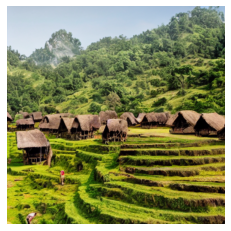

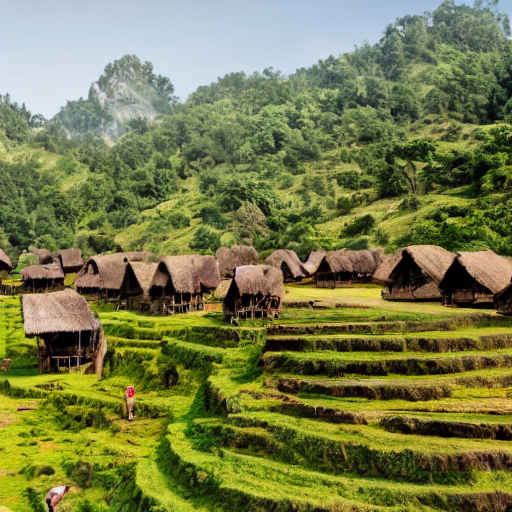

time: 7.61 s (started: 2024-01-09 07:48:56 +00:00)


In [8]:
text_2_image(deci_diffusion_pipeline, "Create an image of a picturesque Indian village with thatched-roof huts, and lush fields")


  0%|          | 0/30 [00:00<?, ?it/s]

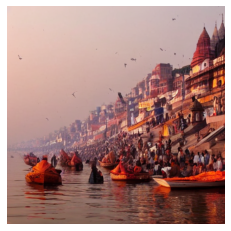

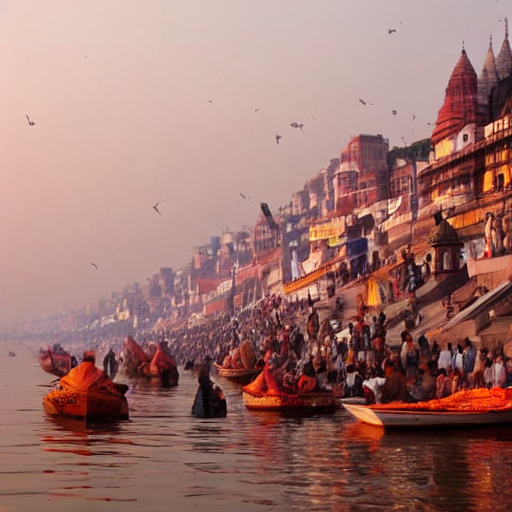

time: 1.22 s (started: 2024-01-09 07:49:46 +00:00)


In [9]:
text_2_image(deci_diffusion_pipeline, "Illustrate a serene view of the Ganges River at Varanasi, with ghats, pilgrims, and the evening Ganga Aarti.")


  0%|          | 0/30 [00:00<?, ?it/s]

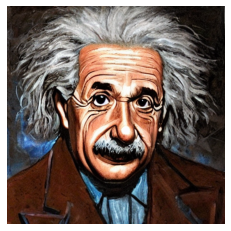

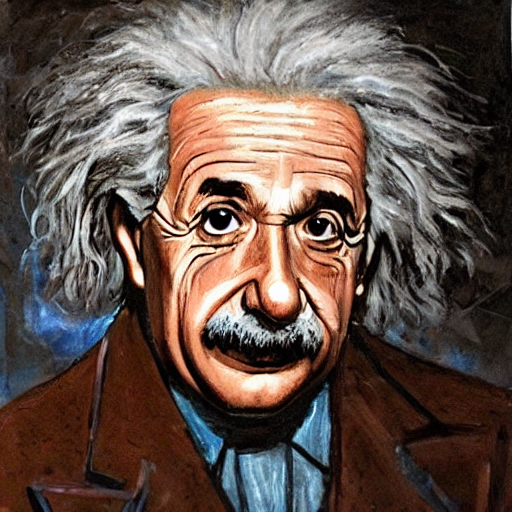

time: 1.2 s (started: 2024-01-09 07:50:12 +00:00)


In [10]:
text_2_image(deci_diffusion_pipeline, "a realistic portrait of albert einstein with a bewildered expression")


  0%|          | 0/30 [00:00<?, ?it/s]

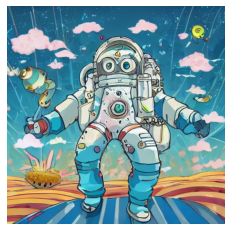

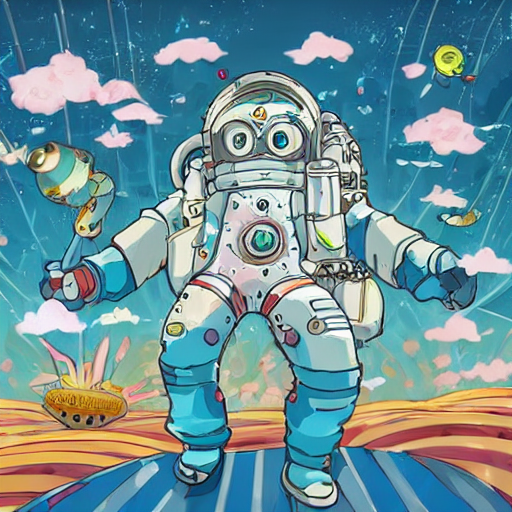

time: 1.23 s (started: 2024-01-09 07:51:02 +00:00)


In [11]:
text_2_image(deci_diffusion_pipeline, "in the style of Takashi Murakami, studio ghibli, bioshock infinite landscape, astronaut in space suit cartoon dynamic pose, fireworks, realistic photo, party, clouds, beautiful sky comets, cosmos, planets, sun")


  0%|          | 0/30 [00:00<?, ?it/s]

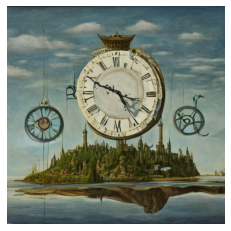

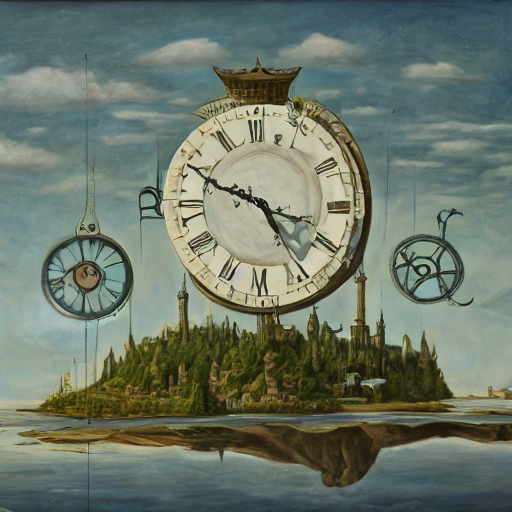

time: 1.27 s (started: 2024-01-09 07:52:12 +00:00)


In [12]:
text_2_image(deci_diffusion_pipeline, "Surrealist painting of a floating island with giant clock gears, populated with mythical creatures")

  0%|          | 0/30 [00:00<?, ?it/s]

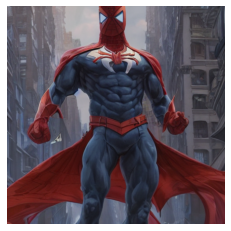

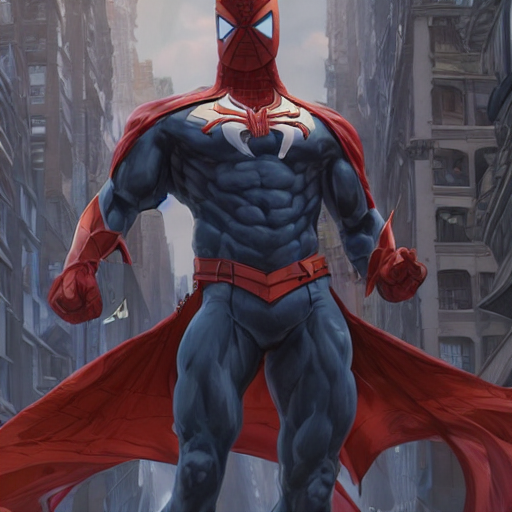

time: 1.3 s (started: 2024-01-09 07:52:47 +00:00)


In [13]:
prompt = "clear portrait of a superhero concept between spiderman and batman, cottagecore!!, background hyper detailed, character concept, full body, dynamic pose, intricate, highly detailed, digital painting, artstation, concept art, smooth, sharp focus, illustration, art by artgerm and greg rutkowski and alphonse mucha"
text_2_image(deci_diffusion_pipeline, prompt)

# Load Stable Diffusion for comparison 

In [4]:
stable_diffusion_pipeline = StableDiffusionPipeline.from_pretrained('runwayml/stable-diffusion-v1-5',
                                                                    torch_dtype=torch.float16)
stable_diffusion_pipeline = stable_diffusion_pipeline.to("cuda")

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


time: 18.8 s (started: 2024-01-09 09:18:07 +00:00)


# Function to generate images using prompt

In [5]:
def text_2_image_SD(pipeline, prompt):

    # Start the timer
    start_time = time.time()

    # Call the pipeline function directly
    result = pipeline([prompt], generator=torch.Generator("cuda").manual_seed(42))

    # Calculate and print the elapsed time
    elapsed_time = time.time() - start_time
    display(HTML(f'<span style="color: #3264ff; font-weight:bold;font-size: 20px;">Time taken to generate: {elapsed_time:.2f} seconds</span>'))

    img = result.images[0]

    # Display the image
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    return img

time: 600 µs (started: 2024-01-09 09:20:14 +00:00)


  0%|          | 0/50 [00:00<?, ?it/s]

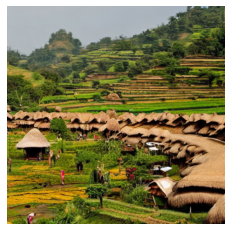

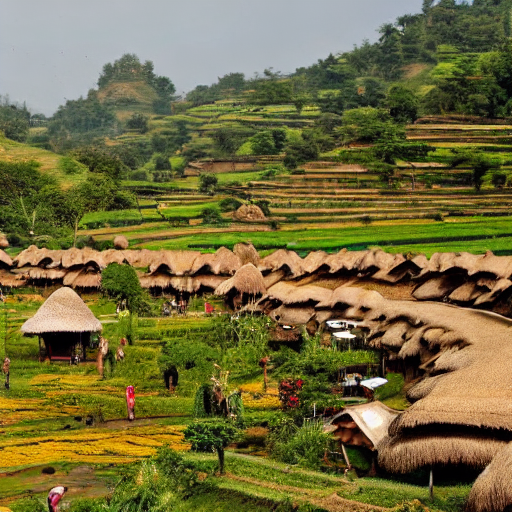

time: 6.17 s (started: 2024-01-09 09:20:41 +00:00)


In [6]:
text_2_image_SD(stable_diffusion_pipeline, "Create an image of a picturesque Indian village with thatched-roof huts, and lush fields")


  0%|          | 0/50 [00:00<?, ?it/s]

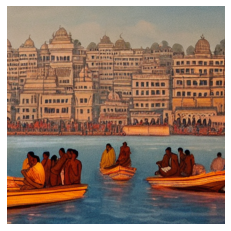

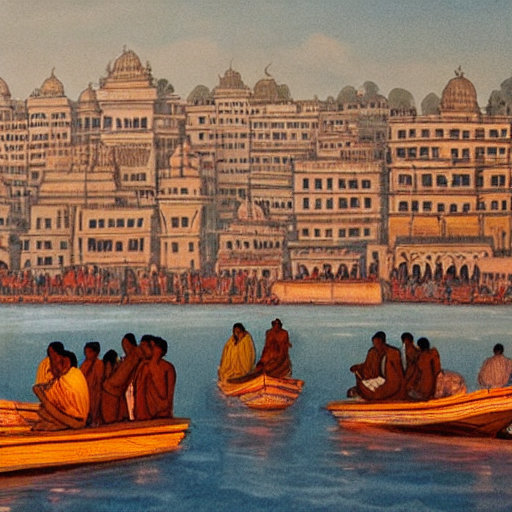

time: 3.07 s (started: 2024-01-09 09:21:30 +00:00)


In [8]:
text_2_image_SD(stable_diffusion_pipeline, "Illustrate a serene view of the Ganges River at Varanasi, with ghats, pilgrims, and the evening Ganga Aarti.")


  0%|          | 0/50 [00:00<?, ?it/s]

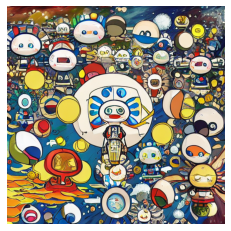

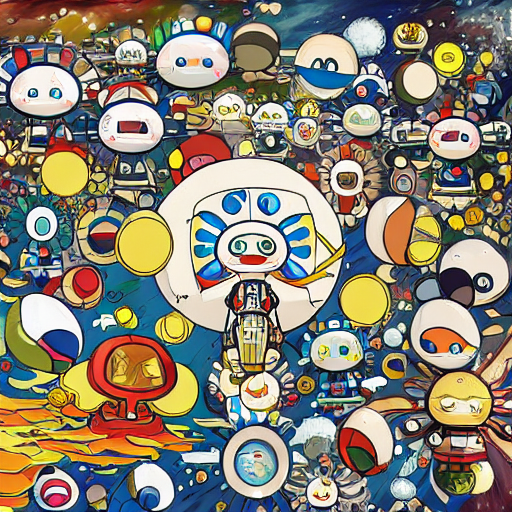

time: 3.09 s (started: 2024-01-09 09:22:08 +00:00)


In [9]:
text_2_image_SD(stable_diffusion_pipeline, "in the style of Takashi Murakami, studio ghibli, bioshock infinite landscape, astronaut in space suit cartoon dynamic pose, fireworks, realistic photo, party, clouds, beautiful sky comets, cosmos, planets, sun")


  0%|          | 0/50 [00:00<?, ?it/s]

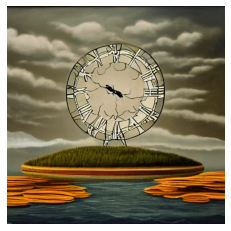

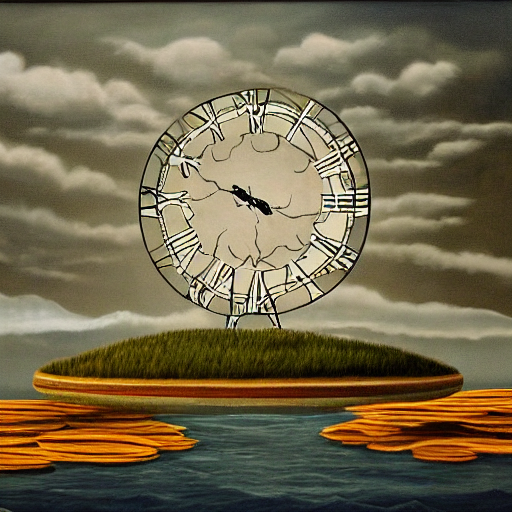

time: 3.09 s (started: 2024-01-09 09:22:55 +00:00)


In [10]:
text_2_image_SD(stable_diffusion_pipeline, "Surrealist painting of a floating island with giant clock gears, populated with mythical creatures")

  0%|          | 0/50 [00:00<?, ?it/s]

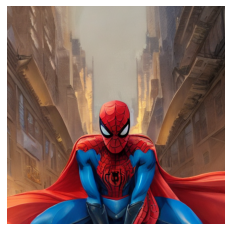

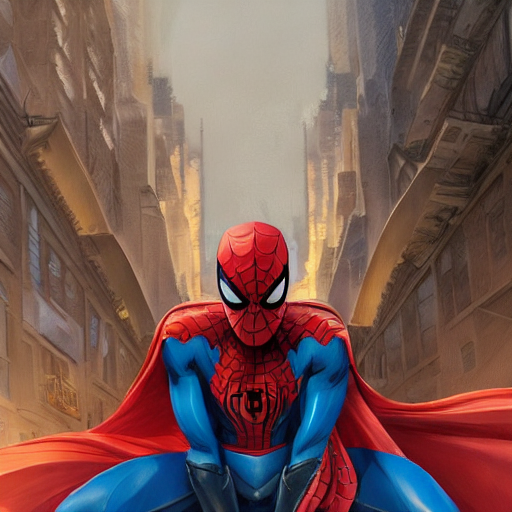

time: 3.12 s (started: 2024-01-09 09:23:44 +00:00)


In [11]:
prompt = "clear portrait of a superhero concept between spiderman and batman, cottagecore!!, background hyper detailed, character concept, full body, dynamic pose, intricate, highly detailed, digital painting, artstation, concept art, smooth, sharp focus, illustration, art by artgerm and greg rutkowski and alphonse mucha"
text_2_image_SD(stable_diffusion_pipeline, prompt)